# Variational Auto-encoder (VAE)

In this notebook, we will demonstrate how to implement a Variational Auto-encoder with Gluon.probability

In [62]:
import time
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet import np, npx
from mxnet.gluon import nn
import matplotlib.pyplot as plt
import mxnet.gluon.probability as mgp
npx.set_np()
data_ctx = mx.cpu()
model_ctx = mx.gpu(0)

In [56]:
def load_data(batch_size):
    mnist_train = gluon.data.vision.MNIST(train=True)
    mnist_test = gluon.data.vision.MNIST(train=False)
    num_worker = 4
    transformer = gluon.data.vision.transforms.ToTensor()
    return (gluon.data.DataLoader(mnist_train.transform_first(transformer),
                                batch_size, shuffle=True,
                                num_workers=num_worker),
          gluon.data.DataLoader(mnist_test.transform_first(transformer),
                                batch_size, shuffle=False,
                                num_workers=num_worker))
                                 

In [100]:
class VAE(gluon.HybridBlock):
    def __init__(self, n_hidden=256, n_latent=2, n_layers=1, n_output=784, act_type='relu', **kwargs):
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.output = None
        self.mu = None
        super(VAE, self).__init__(**kwargs)
        self.encoder = nn.HybridSequential()
        for _ in range(n_layers):
            self.encoder.add(nn.Dense(n_hidden, activation=act_type))
        self.encoder.add(nn.Dense(n_latent*2, activation=None))
        self.decoder = nn.HybridSequential()
        for _ in range(n_layers):
            self.decoder.add(nn.Dense(n_hidden, activation=act_type))
        self.decoder.add(nn.Dense(n_output, activation='sigmoid'))
        
    def encode(self, x):
        h = self.encoder(x)
        loc_scale = np.split(h, 2, 1)
        loc = loc_scale[0]
        log_variance = loc_scale[1]
        scale = np.exp(0.5 * log_variance)
        self.loc = loc
        return mgp.Normal(loc, scale)
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        prior = mgp.Normal(0, 1)
        mvn = self.encode(x)
        z = mvn.sample()
        y = self.decode(z)
        KL = mgp.kl_divergence(mvn, prior).sum(1)
        logloss = np.sum(x * np.log(y+self.soft_zero) + (1-x)
                         * np.log(1-y+self.soft_zero), axis=1)
        loss = -logloss + KL
        return loss

In [101]:
def train(net, n_epoch, print_period, train_iter, test_iter):
    net.initialize(mx.init.Xavier(), ctx=model_ctx)
    net.hybridize()
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                          {'learning_rate': .001})
    training_loss = []
    validation_loss = []
    for epoch in range(n_epoch):
        epoch_loss = 0
        epoch_val_loss = 0

        n_batch_train = 0
        for batch in train_iter:
            n_batch_train += 1
            data = batch[0].as_in_context(model_ctx).reshape(-1, 28 * 28)
            with autograd.record():
                loss = net(data)
            loss.backward()
            trainer.step(data.shape[0])
            epoch_loss += np.mean(loss)

        n_batch_val = 0
        for batch in test_iter:
            n_batch_val += 1
            data = batch[0].as_in_context(model_ctx).reshape(-1, 28 * 28)
            loss = net(data)
            epoch_val_loss += np.mean(loss)

        epoch_loss /= n_batch_train
        epoch_val_loss /= n_batch_val

        training_loss.append(epoch_loss)
        validation_loss.append(epoch_val_loss)

        if epoch % max(print_period, 1) == 0:
            print('Epoch{}, Training loss {:.2f}, Validation loss {:.2f}'.format(
              epoch, float(epoch_loss), float(epoch_val_loss)))

In [102]:
n_hidden = 128
n_latent = 40
n_layers = 3  # num of dense layers in encoder and decoder respectively
n_output = 784
batch_size = 128
model_prefix = 'vae_gluon_{}d{}l{}h.params'.format(
  n_latent, n_layers, n_hidden)
net = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers,
        n_output=n_output)
net.hybridize()
n_epoch = 50
print_period = n_epoch // 10
train_set, test_set = load_data(batch_size)
start = time.time()
train(net, n_epoch, print_period, train_set, test_set)
end = time.time()
print('Time elapsed: {:.2f}s'.format(end - start))

Epoch0, Training loss 196.94, Validation loss 159.10
Epoch5, Training loss 118.83, Validation loss 117.58
Epoch10, Training loss 113.12, Validation loss 112.36
Epoch15, Training loss 109.99, Validation loss 109.53
Epoch20, Training loss 108.10, Validation loss 107.91
Epoch25, Training loss 106.99, Validation loss 106.77
Epoch30, Training loss 106.14, Validation loss 106.16
Epoch35, Training loss 105.52, Validation loss 106.44
Epoch40, Training loss 104.94, Validation loss 105.92
Epoch45, Training loss 104.49, Validation loss 105.46
Time elapsed: 382.02s


In [64]:
qz_x = None
for batch in test_set:
    data = batch[0].as_in_context(model_ctx).reshape(-1, 28 * 28)
    qz_x = net.encode(data)
    break

## Reconstruction visualiztion

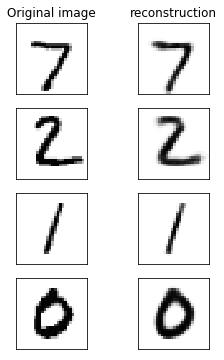

In [99]:
num_samples = 4
fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(4, 6), subplot_kw={'xticks': [], 'yticks': []})
axes[0, 0].set_title('Original image')
axes[0, 1].set_title('reconstruction')
for i in range(num_samples):
    axes[i, 0].imshow(1 - data[i].squeeze().reshape(28, 28).asnumpy(), cmap='gray')
    axes[i, 1].imshow(1 - net.decode(qz_x.sample())[i].reshape(28, 28).asnumpy(), cmap='gray')

## Visualization of the posterior collapse phenomenon

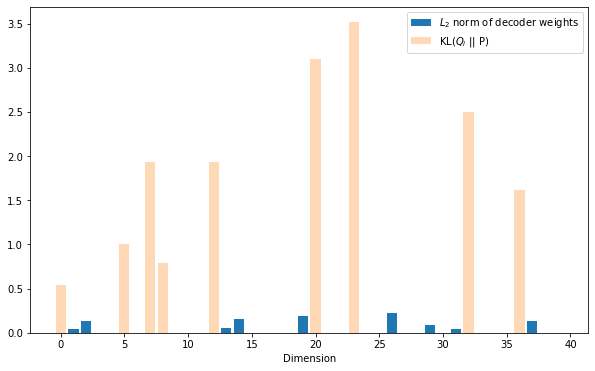

In [63]:
x = np.arange(n_latent).asnumpy()
plt.figure(figsize=(10,6))
plt.bar(x, (net.decoder[0].weight.data() ** 2).mean(0).asnumpy(), alpha=1.0, label='$L_2$ norm of decoder weights')
plt.bar(x, mgp.kl_divergence(qz_x, mgp.Normal(0, 1))[0].asnumpy(), alpha=0.3, label='KL($Q_i$ || P)')
plt.legend()
plt.xlabel("Dimension")
plt.savefig("kl_anneal.pdf")